In [1]:
import numpy as np
import pickle
from math import *
import copy
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


In [2]:
def tanh(x):
    return np.tanh(x)

# Function to perform predictions using the extracted parameters
def custom_predict(input_data, model):
    # Extract model parameters (weights and biases) for each layer
    model_parameters = []
    for layer in model.layers:
        layer_weights = layer.get_weights()
        model_parameters.append(layer_weights)
        
    for i, layer_params in enumerate(model_parameters):
        weights, biases = layer_params
        # Compute the linear transformation (z) for this layer
        z = np.dot(input_data, weights) + biases
        # Apply the 'tanh' activation function for all layers except the last one
        if i < len(model_parameters) - 1:
            output_data = tanh(z)
        else:
            # For the last layer, do not apply the 'tanh' activation function
            output_data = z
        # Set the output of this layer as the input for the next layer
        input_data = output_data

    # The final output is the prediction
    return output_data

In [3]:
global kn, kt, phig, alpOmega, belOmega, alpha0, ntheta, radius, confining
"""
Constitutive paramters:
- Normal contact stiffness (kn)
- Contact stiffness ratio kn/kt (ratioK)
- Inter-granular friction angle (phig)
- Anisotropy of the distribution (alphaOmega)
- Principal direction of anisotropy (beltaOmega)
- Initial opening angle (alpha0)
"""
kn = 2.0e8; kt = 0.5 * kn; phig = 30*pi/180; alpOmega = 0; belOmega = 0; alpha0 = 50* pi / 180; confining = 200000 # paraThesis Guillaume in th


"""
Computation constant:
- Radius of particles (radius)
- Number of the directions of cells (ntheta)
- The limits of the directions of cells (thetaMin, thetaMax)
- localization hypothesis (locV): 'Vhexagon', 'Vboxin', 'Vboxout'
"""
radius = 1
ntheta = 360
thetaMin = 0
thetaMax = pi
locV = 'Vhexagon'
savepath = "/home/naa/Desktop/H_model_prediction/original_paraThesis_p200_al50_"

# Labels of grains in the hexagon
#     O1
#   O2  O6
#   O3  O5
#     O4

In [4]:
class MesoCell:
    """
    Define a class of meso cell object. Each hexagon has the following attributes:
    - its id which related to the direction of the cell(id)
    - its branch lenghts (d1, d2)
    - its opening angle (alpha)
    - the normal and tangential forces of contant 1 (Fn1, Ft1) (see Nicot et al 2011)
    - the normal forces of contact 2 (Fn2)
    - its hexagon lengths(l1,l2)
    - three options of the volume (Vboxout, Vboxin, Vhexagon)
    - its direction (theta)
    - the weight of this direction (ome)
    - the Love-Weber stress multiplied by volume in the local frame (n, t) (vsignn, vsigtt)
    - the Love-Weber stress multiplied by volume in the global frame (e1, e2) (vsig11, vsig22)
    - the fabric tensor multiplied by the number of contacts in the local frame (n, t) (cfabnn, cfabtt)
    - the fabric tensor  multiplied by the number of contacts in the global frame (e1, e2) (cfab11, cfab22)
    - whether sliding exsits at the contact 1 (Sliding1)
    - whether the contact between grain1 and 2 (grains 2 and 3) is open (opening12, opening23)
    - whether the particle 2 and 4 or particle 2 and 6 are contacted (IsCont14, IsCont26)
    """

    def __init__(self, id, theta):
        self.id = id
        self.alpha = alpha0
        self.radius = radius
        self.d1 = 2 * self.radius
        self.d2 = 2 * self.radius
        self.Fn1 = 0.0
        self.Ft1 = 0.0
        self.Fn2 = 0.0
        self.nContact = 6

        self.l1 = self.d2 + 2 * self.d1 * cos(self.alpha)
        self.l2 = 2 * self.d1 * sin(self.alpha)
        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1
        self.Vcell0 = (self.l1 + Vr1 * 2 * self.radius) * (self.l2 + Vr2 * 2 * self.radius)

        self.theta = theta
        self.omega = 1 / pi * (1 + alpOmega * cos(2 * (theta - belOmega))) * pi / ntheta # indeed it is omega*dtheta

        self.vsignn = 0.0
        self.vsigtt = 0.0

        self.vsig11 = 0.0
        self.vsig22 = 0.0
        self.vsig12 = 0.0

        self.Sliding1 = False
        self.Opening12 = False # the contact between grains1 and 2
        self.Opening23 = False # the contact between grains2 and 3
        self.IsCont14 = False
        self.IsCont26 = False
        
    def node_position(self):
        r = self.radius
        l1 = self.l1
        l2 = self.l2
        cosa =np.cos(self.alpha)
        sina =np.sin(self.alpha)
        d1 = self.d1
        d2 = self.d2
        
        x = [0,-d1*sina,-d1*sina,0,d1*sina,d1*sina]
        y = [d2/2+d1*cosa,d2/2,-d2/2,-d2/2-d1*cosa,-d2/2,d2/2]
        
        cos_theta =np.cos(self.theta)
        sin_theta =np.sin(self.theta)
            
        n = len(x)
        for i in range(n):
            x0,y0 = x[i],y[i]
            x[i] =cos_theta*x0 + sin_theta*y0
            y[i] =sin_theta*x0 + cos_theta*y0
        
        return (x,y)

    def Substrain(self, deps11, deps22, deps12):
        """
        Update cell information for given macroscopic incremental strains (soil mechanics sign convention)
        """
        G2 = 0  # 1: considering G2 in the new version of H (2021); 0: without G2 in the old version (Nicot et al 2011)

        # select the localization hypothesis
        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1

        dl1 = -self.l1 * (deps11 * pow(cos(self.theta), 2.0) + deps22 * pow(sin(self.theta), 2.0) + 2 * deps12 * cos(self.theta) * sin(self.theta))
        dl2 = -self.l2 * (deps11 * pow(sin(self.theta), 2.0) + deps22 * pow(cos(self.theta), 2.0) - 2 * deps12 * cos(self.theta) * sin(self.theta))

        # geometrical relationships
        K11 = 2.0 * cos(self.alpha)
        K12 = 1.0
        K13 = -2.0 * self.d1 * sin(self.alpha)
        K21 = 2.0 * sin(self.alpha)
        K22 = 0.0
        K23 = 2.0 * self.d1 * cos(self.alpha)

        # closure : static equilibrium, assume no sliding
        K31 = cos(self.alpha)
        K32 = -1.0
        K33 = (self.Fn1 * sin(self.alpha) - self.Ft1 * cos(self.alpha) - kt * self.d1 * (G2 + sin(self.alpha))) / kn

        # right hand side of the compatibility equation, assume no sliding
        L1 = dl1
        L2 = dl2
        L3 = 0

        K = np.array([[K11, K12, K13], [K21, K22, K23], [K31, K32, K33]])
        L = np.array([L1, L2, L3])
        solve = np.linalg.solve(K, L)  # check whether it solves K.X=L with X unknown

        dd1 = solve[0]
        dd2 = solve[1]
        dalpha = solve[2]

        dFn1 = -kn * dd1
        dFt1 = kt * self.d1 * dalpha
        dFn2 = -kn * dd2

        if abs(self.Ft1 + dFt1) < abs(tan(phig) * (self.Fn1 - kn * dd1)):
            self.Sliding1 = False
        else:
            self.Sliding1 = True
            if self.Ft1 > 0:
                xi = 1
            else:
                xi = -1

            K31 = cos(self.alpha) + xi * tan(phig) * (G2 + sin(self.alpha))
            K33 = (self.Fn1 * sin(self.alpha) - self.Ft1 * cos(self.alpha)) / kn
            L3 = (xi * (G2 + sin(self.alpha)) * (tan(phig) * self.Fn1 - self.Ft1)) / kn

            K = np.array([[K11, K12, K13], [K21, K22, K23], [K31, K32, K33]])
            L = np.array([L1, L2, L3])
            solve = np.linalg.solve(K, L)

            dd1 = solve[0]
            dd2 = solve[1]
            dalpha = solve[2]

            dFn1 = -kn * dd1
            dFn2 = -kn * dd2
            dFt1 = xi*tan(phig)*(self.Fn1+dFn1)-self.Ft1

        self.d1 += dd1
        self.d2 += dd2
        self.alpha += dalpha

        self.l1 += dl1
        self.l2 += dl2

        self.Vcell = (self.l1 + Vr2 * 2 * self.radius) * (self.l2 + Vr1 * 2 * self.radius)
        self.Fn1 += dFn1
        self.Ft1 += dFt1
        self.Fn2 += dFn2

        # Check for pathological cases
        vcorsignn, vcorsigtt = 0, 0

        if self.l1 - 2* self.radius <= 0:
            self.IsCont14 = True
            self.nContact = 7
            vcorsignn = kn * (2 * self.radius - self.l1) * self.l1
        else:
            self.IsCont14 = False


        if self.l2 - 2 * self.radius <= 0:
            self.IsCont26 = True
            self.nContact = 8
            vcorsigtt = 2 * kn * (2 * self.radius - self.l2) * self.l2
        else:
            self.IsCont26 = False


        if self.d1 > 2.0:
            self.Fn2 = 0
            self.Fn1, self.Ft1 = 0, 0
            self.Opening12 = True
            #self.Vcell = 0
        else:
            self.Opening12 = False

        if self.d2 > 2.0: #self.Fn2 < 0:
            self.Fn2 = 0
            self.Fn1, self.Ft1 = 0, 0
            self.Opening23 = True
            #self.Vcell = 0
        else:
            self.Opening23 = False

        # Update the stress (it includes pathological corrections)
        self.vsignn = 4.0 * self.Fn1 * self.d1 * pow(cos(self.alpha), 2.0) + 4.0 * self.Ft1 * self.d1 * cos(
            self.alpha) * sin(self.alpha) + 2.0 * self.Fn2 * self.d2 + vcorsignn
        self.vsigtt = 4.0 * self.Fn1 * self.d1 * pow(sin(self.alpha), 2.0) - 4.0 * self.Ft1 * self.d1 * cos(
            self.alpha) * sin(self.alpha) + vcorsigtt

        self.vsig11 = self.vsignn * cos(self.theta) ** 2 + self.vsigtt * sin(self.theta) ** 2
        self.vsig22 = self.vsignn * sin(self.theta) ** 2 + self.vsigtt * cos(self.theta) ** 2
        self.vsig12 = (self.vsignn - self.vsigtt) * sin(self.theta) * cos(self.theta)


In [5]:
class ANN_MesoCell:
    """
    Define a class of meso cell object.
    But using machine learning.
    """

    def __init__(self, id, theta):
        self.id = id
        self.alpha = alpha0
        self.radius = radius
        self.d1 = 2 * self.radius
        self.d2 = 2 * self.radius
        self.Fn1 = 0.0
        self.Ft1 = 0.0
        self.Fn2 = 0.0
        self.nContact = 6

        self.l1 = self.d2 + 2 * self.d1 * cos(self.alpha)
        self.l2 = 2 * self.d1 * sin(self.alpha)
        
        self.l10 = self.l1
        self.l20 = self.l2

        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1
        self.Vcell0 = (self.l1 + Vr1 * 2 * self.radius) * (self.l2 + Vr2 * 2 * self.radius)

        self.theta = theta
        self.omega = 1 / pi * (1 + alpOmega * cos(2 * (theta - belOmega))) * pi / ntheta # indeed it is omega*dtheta

        self.vsignn = 0.0
        self.vsigtt = 0.0

        self.vsig11 = 0.0
        self.vsig22 = 0.0
        self.vsig12 = 0.0

        self.Sliding1 = False
        self.Opening12 = False # the contact between grains1 and 2
        self.Opening23 = False # the contact between grains2 and 3
        self.IsCont14 = False
        self.IsCont26 = False
        
        self.f_ann = False
        
    def node_position(self):
        r = self.radius
        l1 = self.l1
        l2 = self.l2
        cosa =np.cos(self.alpha)
        sina =np.sin(self.alpha)
        d1 = self.d1
        d2 = self.d2
        
        x = [0,-d1*sina,-d1*sina,0,d1*sina,d1*sina]
        y = [d2/2+d1*cosa,d2/2,-d2/2,-d2/2-d1*cosa,-d2/2,d2/2]
        
        cos_theta =np.cos(self.theta)
        sin_theta =np.sin(self.theta)
            
        n = len(x)
        for i in range(n):
            x0,y0 = x[i],y[i]
            x[i] =cos_theta*x0 + sin_theta*y0
            y[i] =sin_theta*x0 + cos_theta*y0
        
        return (x,y)
    
    def first_substrain(self,dl1,dl2):
        G2 = 0  # 1: considering G2 in the new version of H (2021); 0: without G2 in the old version (Nicot et al 2011)

        # select the localization hypothesis
        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1
            
        e_max = 0.1 / 100
        e_l = (dl1 ** 2 + dl2 ** 2) ** 0.5
        ann_l1 = 0
        ann_l2 = 0
        
        if e_l > e_max:
            el1 = e_max / e_l * dl1
            el2 = e_max / e_l * dl2
            ann_l1 = dl1 - el1
            ann_l2 = dl2 - el2
            dl1 = el1
            dl2 = el2
            
        # geometrical relationships
        K11 = 2.0 * cos(self.alpha)
        K12 = 1.0
        K13 = -2.0 * self.d1 * sin(self.alpha)
        K21 = 2.0 * sin(self.alpha)
        K22 = 0.0
        K23 = 2.0 * self.d1 * cos(self.alpha)

        # closure : static equilibrium, assume no sliding
        K31 = cos(self.alpha)
        K32 = -1.0
        K33 = (self.Fn1 * sin(self.alpha) - self.Ft1 * cos(self.alpha) - kt * self.d1 * (G2 + sin(self.alpha))) / kn

        # right hand side of the compatibility equation, assume no sliding
        L1 = dl1
        L2 = dl2
        L3 = 0

        K = np.array([[K11, K12, K13], [K21, K22, K23], [K31, K32, K33]])
        L = np.array([L1, L2, L3])
        solve = np.linalg.solve(K, L)  # check whether it solves K.X=L with X unknown

        dd1 = solve[0]
        dd2 = solve[1]
        dalpha = solve[2]

        dFn1 = -kn * dd1
        dFt1 = kt * self.d1 * dalpha
        dFn2 = -kn * dd2

        if abs(self.Ft1 + dFt1) < abs(tan(phig) * (self.Fn1 - kn * dd1)):
            self.Sliding1 = False
        else:
            self.Sliding1 = True
            if self.Ft1 > 0:
                xi = 1
            else:
                xi = -1

            K31 = cos(self.alpha) + xi * tan(phig) * (G2 + sin(self.alpha))
            K33 = (self.Fn1 * sin(self.alpha) - self.Ft1 * cos(self.alpha)) / kn
            L3 = (xi * (G2 + sin(self.alpha)) * (tan(phig) * self.Fn1 - self.Ft1)) / kn

            K = np.array([[K11, K12, K13], [K21, K22, K23], [K31, K32, K33]])
            L = np.array([L1, L2, L3])
            solve = np.linalg.solve(K, L)

            dd1 = solve[0]
            dd2 = solve[1]
            dalpha = solve[2]

            dFn1 = -kn * dd1
            dFn2 = -kn * dd2
            dFt1 = xi*tan(phig)*(self.Fn1+dFn1)-self.Ft1

        self.d1 += dd1
        self.d2 += dd2
        self.alpha += dalpha

        self.l1 += dl1
        self.l2 += dl2

        self.Vcell = (self.l1 + Vr2 * 2 * self.radius) * (self.l2 + Vr1 * 2 * self.radius)
        self.Fn1 += dFn1
        self.Ft1 += dFt1
        self.Fn2 += dFn2
        
        if ann_l1 !=0 or ann_l2 !=0:
            # Check for pathological cases
            vcorsignn, vcorsigtt = 0, 0

            if self.l1 - 2* self.radius <= 0:
                self.IsCont14 = True
                self.nContact = 7
                vcorsignn = kn * (2 * self.radius - self.l1) * self.l1
            else:
                self.IsCont14 = False


            if self.l2 - 2 * self.radius <= 0:
                self.IsCont26 = True
                self.nContact = 8
                vcorsigtt = 2 * kn * (2 * self.radius - self.l2) * self.l2
            else:
                self.IsCont26 = False


            if self.d1 > 2.0:
                self.Fn2 = 0
                self.Fn1, self.Ft1 = 0, 0
                self.Opening12 = True
                #self.Vcell = 0
            else:
                self.Opening12 = False

            if self.d2 > 2.0: #self.Fn2 < 0:
                self.Fn2 = 0
                self.Fn1, self.Ft1 = 0, 0
                self.Opening23 = True
                #self.Vcell = 0
            else:
                self.Opening23 = False

            # Update the stress (it includes pathological corrections)
            self.vsignn = 4.0 * self.Fn1 * self.d1 * pow(cos(self.alpha), 2.0) + 4.0 * self.Ft1 * self.d1 * cos(
                self.alpha) * sin(self.alpha) + 2.0 * self.Fn2 * self.d2 + vcorsignn
            self.vsigtt = 4.0 * self.Fn1 * self.d1 * pow(sin(self.alpha), 2.0) - 4.0 * self.Ft1 * self.d1 * cos(
                self.alpha) * sin(self.alpha) + vcorsigtt

            self.vsig11 = self.vsignn * cos(self.theta) ** 2 + self.vsigtt * sin(self.theta) ** 2
            self.vsig22 = self.vsignn * sin(self.theta) ** 2 + self.vsigtt * cos(self.theta) ** 2
            self.vsig12 = (self.vsignn - self.vsigtt) * sin(self.theta) * cos(self.theta)
            
            dl1 = ann_l1
            dl2 = ann_l2
            edl1 = dl1/self.l10 
            edl2 = dl2/self.l20 

            data = np.array([[edl1, edl2, self.alpha, self.l1, self.l2, self.Fn1 / kn, self.Fn2 / kn, self.Ft1 / kt]])
            data_scaled_robust = x_scaler_robust.transform(data)

            prediction = custom_predict(data_scaled_robust, model)
            N1_p, N2_p, T1_p, alpha_p = prediction[-1]

    #             N1_p = N1_p * kn
    #             N2_p = N2_p * kn
    #             T1_p = T1_p * kt       

    #         print(N1_p,N2_p, T1_p)

            self.alpha = alpha_p * 1e-4
            self.l1 += dl1
            self.l2 += dl2
            self.Fn1 = N1_p * 1e4
            self.Ft1 = T1_p * 1e4
            self.Fn2 = N2_p * 1e4

    #         print(self.Fn1, self.Fn2, self.Ft1)
    #         print(self.d1, self.d2)

            self.d1 = self.l2/ (2 * sin(self.alpha))
            self.d2 = self.l1 - 2 * self.d1 * cos(self.alpha)
            self.Vcell = (self.l1 + Vr2 * 2 * self.radius) * (self.l2 + Vr1 * 2 * self.radius)

            

    def Substrain(self, deps11, deps22, deps12):
        """
        Update cell information for given macroscopic incremental strains (soil mechanics sign convention)
        """
        G2 = 0  # 1: considering G2 in the new version of H (2021); 0: without G2 in the old version (Nicot et al 2011)

        # select the localization hypothesis
        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1

        dl1 = -self.l1 * (deps11 * pow(cos(self.theta), 2.0) + deps22 * pow(sin(self.theta), 2.0) + 2 * deps12 * cos(self.theta) * sin(self.theta))
        dl2 = -self.l2 * (deps11 * pow(sin(self.theta), 2.0) + deps22 * pow(cos(self.theta), 2.0) - 2 * deps12 * cos(self.theta) * sin(self.theta))
        
        if self.f_ann:
            edl1 = dl1/self.l10 
            edl2 = dl2/self.l20 

            data = np.array([[edl1, edl2, self.alpha, self.l1, self.l2, self.Fn1 / kn, self.Fn2 / kn, self.Ft1 / kt]])
            data_scaled_robust = x_scaler_robust.transform(data)

            prediction = custom_predict(data_scaled_robust, model)
            N1_p, N2_p, T1_p, alpha_p = prediction[-1]

    #             N1_p = N1_p * kn
    #             N2_p = N2_p * kn
    #             T1_p = T1_p * kt       

    #         print(N1_p,N2_p, T1_p)

            self.alpha = alpha_p * 1e-4
            self.l1 += dl1
            self.l2 += dl2
            self.Fn1 = N1_p * 1e4
            self.Ft1 = T1_p * 1e4
            self.Fn2 = N2_p * 1e4

    #         print(self.Fn1, self.Fn2, self.Ft1)
    #         print(self.d1, self.d2)

            self.d1 = self.l2/ (2 * sin(self.alpha))
            self.d2 = self.l1 - 2 * self.d1 * cos(self.alpha)
            self.Vcell = (self.l1 + Vr2 * 2 * self.radius) * (self.l2 + Vr1 * 2 * self.radius)

    #         print(self.d1, self.d2)
    
        else:
            f_ann = True
            self.first_substrain(dl1,dl2)
        
        # Check for pathological cases
        vcorsignn, vcorsigtt = 0, 0

        if self.l1 - 2* self.radius <= 0:
            self.IsCont14 = True
            self.nContact = 7
            vcorsignn = kn * (2 * self.radius - self.l1) * self.l1
        else:
            self.IsCont14 = False


        if self.l2 - 2 * self.radius <= 0:
            self.IsCont26 = True
            self.nContact = 8
            vcorsigtt = 2 * kn * (2 * self.radius - self.l2) * self.l2
        else:
            self.IsCont26 = False


        if self.d1 > 2.0:
            self.Fn2 = 0
            self.Fn1, self.Ft1 = 0, 0
            self.Opening12 = True
            #self.Vcell = 0
        else:
            self.Opening12 = False

        if self.d2 > 2.0: #self.Fn2 < 0:
            self.Fn2 = 0
            self.Fn1, self.Ft1 = 0, 0
            self.Opening23 = True
            #self.Vcell = 0
        else:
            self.Opening23 = False

        # Update the stress (it includes pathological corrections)
        self.vsignn = 4.0 * self.Fn1 * self.d1 * pow(cos(self.alpha), 2.0) + 4.0 * self.Ft1 * self.d1 * cos(
            self.alpha) * sin(self.alpha) + 2.0 * self.Fn2 * self.d2 + vcorsignn
        self.vsigtt = 4.0 * self.Fn1 * self.d1 * pow(sin(self.alpha), 2.0) - 4.0 * self.Ft1 * self.d1 * cos(
            self.alpha) * sin(self.alpha) + vcorsigtt

        self.vsig11 = self.vsignn * cos(self.theta) ** 2 + self.vsigtt * sin(self.theta) ** 2
        self.vsig22 = self.vsignn * sin(self.theta) ** 2 + self.vsigtt * cos(self.theta) ** 2
        self.vsig12 = (self.vsignn - self.vsigtt) * sin(self.theta) * cos(self.theta)
        
#         print(self.Fn1, self.Fn2, self.Ft1)


In [6]:
class MacREV:
    """
    Define a class of MacREV objects. Each texture has the following
    attributes:
    - stresses (sig11, sig22, sig12)
    - strains (eps11, eps22, eps12)
    - the global volume (vol)
    - the dictionary for initialized cells with their ids as keys (mesoCell)
    """

    def __init__(self, MesoCell):
        self.sig11 = 0.0
        self.sig22 = 0.0
        self.sig12 = 0.0

        self.eps11 = 0.0
        self.eps22 = 0.0
        self.eps12 = 0.0

        self.mesoCell = {}
        self.specialMeso = {} #save all special cells
        vol0 = 0.0
        for i in range(ntheta):
            id = i
            thetai = thetaMin + i * (thetaMax - thetaMin) / ntheta
            celli = MesoCell(id, thetai)
            vol0 += celli.Vcell0 * celli.omega
            self.mesoCell[id] = celli
        self.volO = vol0
        self.vol = self.volO

    def Step(self, deps11, deps22, deps12, t = 0):
        self.specialMeso["Open12"] = []
        self.specialMeso["Open23"] = []
        self.specialMeso["Contact14"] = []
        self.specialMeso["Contact26"] = []
        vsig11, vsig22, vsig12 = 0.0, 0.0, 0.0
        vol = 0.0
        for id, celli in self.mesoCell.items():
            celli.Substrain(deps11, deps22, deps12)
            vsig11 += celli.vsig11 * celli.omega
            vsig22 += celli.vsig22 * celli.omega
            vsig12 += celli.vsig12 * celli.omega
            if t == 1:
                if celli.Opening12 == True: self.specialMeso["Open12"] += [id]
                if celli.Opening23 == True: self.specialMeso["Open23"] += [id]
                if celli.IsCont14 == True: self.specialMeso["Contact14"] += [id]
                if celli.IsCont26 == True: self.specialMeso["Contact26"] += [id]

        self.vol = self.volO * (1 - self.eps11) * (1 - self.eps22)
        self.sig11 = vsig11 / self.vol
        self.sig22 = vsig22 / self.vol
        self.sig12 = vsig12 / self.vol

        self.eps11 += deps11
        self.eps22 += deps22
        self.eps12 += deps12


In [7]:
class Loading:
    def __init__(self, MacREV):
        self.REV = MacREV
        self.Nstep = 0 # number of computation steps
        self.adjE = 0.0  # lateral adjustment of the strain
        self.res = {"test":[], "step":[], "eps11": [], "eps22": [], "eps12": [], "sig11": [], "sig22": [], "sig12": []}  # result storage

    def isoTest(self, vit=1.0e3/kn, sigConfining=confining):  # vit is the strain increment between two steps
        while 0.5 * (self.REV.sig11 + self.REV.sig22) <= sigConfining:
            # cn = 0  # internal number of steps to find the lateral adjustment strain
            # self.adjE = 0
            # copyREV = self._copyREV()
            # copyREV.Step(vit, 0, 0)  # first guess : oedometer compression
            # while abs(copyREV.sig22 - copyREV.sig11) / sigConfining > 10 ** -4:
            #     cn += 1
            #     if copyREV.sig22 > self.REV.sig11:
            #         self.adjE -= vit/20# reduce lateral strain
            #     else:
            #         self.adjE += vit/20# increase lateral strain
            #     copyREV = self._copyREV()
            #     copyREV.Step(vit, self.adjE, 0)

            # impose the "real" incremental strain step
            self.REV.Step(vit, vit, 0, t = 1)
            self.Nstep += 1

            # self.REV.Step(vit, vit, 0) # 0.6 50degree 0.584  'vit, 0.591*vit' para2
            # self.Nstep += 1
            if self.Nstep % 1 == 0:
                self._output(test="iso")
                self._save("iso")
#                 self._printSpecialMeso()
#                 print("iso:", "eps11=", self.REV.eps11, "eps22=", self.REV.eps22, "S11=", self.REV.sig11,
#                       "S22=", self.REV.sig22, "alpha=",self.REV.mesoCell[90].alpha*180/pi,
#                       "theta = ", self.REV.mesoCell[90].theta*180/pi)

    def _copyREV(self):
        # copy the REV to find appropriate lateral strain in biax loading
        copyREV = copy.deepcopy(self.REV)
        return copyREV


    def biaTest(self, vit=5.0e3/kn, sigConfining=confining, Eps1=0.01):
        while self.REV.eps11 < Eps1:
            # loop to find the lateral strain increment to impose
            cn = 0  # internal number of steps to find the lateral adjustment strain
            self.adjE = 0
            copyREV = self._copyREV()
            copyREV.Step(vit, 0, 0)  # first guess : oedometer compression
            while abs(copyREV.sig22 - sigConfining) / sigConfining > 10e-3:
                cn += 1
                if copyREV.sig22 > sigConfining:
                    self.adjE -= (abs(copyREV.sig22-sigConfining)*10e-2)/kn# reduce lateral strain
                else:
                    self.adjE += (abs(copyREV.sig22-sigConfining)*10e-2)/kn# increase lateral strain
                copyREV = self._copyREV()
                copyREV.Step(vit, self.adjE, 0)
#                if cn % 20 == 0:
#                     print(cn, vit, self.adjE)
#                     print("copybia:", "eps11=", copyREV.eps11, "eps22=", copyREV.eps22, "S11=",copyREV.sig11,
#                           "S22=", copyREV.sig22, "alpha=", copyREV.mesoCell[90].alpha * 180 / pi,
#                           "theta = ", copyREV.mesoCell[90].theta * 180 / pi)

            # impose the "real" incremental strain step
            self.REV.Step(vit, self.adjE, 0, t = 1)
            self.Nstep += 1
            if self.Nstep % 1 == 0:
                self._output(test="bia")
                self._save("bia")
#                 self._printSpecialMeso()
#                 print("bia:", "eps11=", self.REV.eps11, "eps22=", self.REV.eps22, "S11=", self.REV.sig11,
#                       "S22=", self.REV.sig22, "alpha=", self.REV.mesoCell[90].alpha * 180 / pi,
#                       "vertical_theta = ", self.REV.mesoCell[90].theta * 180 / pi)
#                 print("bia:", 'deps11:', vit, 'deps22:', self.adjE)


    def proTest(self, vit=1.0e-7, ratio = -1, Eps1=0.01): # deps22 = deps11 * ratio
        while self.REV.eps11 < Eps1:
            self.REV.Step(vit, vit*ratio, 0, t = 1)
            self.Nstep += 1
            if self.Nstep % 1 == 0:
                self._output(test="pro")
                self._save("pro")
#                 self._printSpecialMeso()
#                 print("pro:", "eps11=", self.REV.eps11, "eps22=", self.REV.eps22, "S11=", self.REV.sig11,
#                       "S22=", self.REV.sig22, "alpha=",self.REV.mesoCell[0].alpha*180/pi)


    def _output(self, name=savepath+locV+"0223", test=""):
        name='Measocelltest'
        f = open(name, 'a')
        print(test, self.Nstep, self.REV.eps11, self.REV.eps22, self.REV.eps12, self.REV.sig11, self.REV.sig22,
              self.REV.sig12, self.REV.mesoCell[90].alpha*180/pi, self.REV.mesoCell[90].theta*180/pi,
              self.REV.mesoCell[90].d1, self.REV.mesoCell[90].d2, file=f)
        f.close

    def _save(self, test="iso"):
        self.res["test"] += [test]
        self.res["step"] += [self.Nstep]
        self.res["eps11"] += [self.REV.eps11]
        self.res["eps22"] += [self.REV.eps22]
        self.res["eps12"] += [self.REV.eps12]
        self.res["sig11"] += [self.REV.sig11]
        self.res["sig22"] += [self.REV.sig22]
        self.res["sig12"] += [self.REV.sig12]

    def _printSpecialMeso(self):
        #print the id list of special cells
        print("Open12", self.REV.specialMeso["Open12"])
        print("Open23", self.REV.specialMeso["Open23"])
        print("Contact14", self.REV.specialMeso["Contact14"])
        print("Contact26", self.REV.specialMeso["Contact26"])

    def draw(self, test="all"):
        if test == "sig":
            plt.figure(1)
            plt.plot(self.res["eps11"], self.res["sig11"], "r", label="$sig11$")
            plt.plot(self.res["eps11"], self.res["sig22"], "b", label="$sig22$")
            plt.xlabel('eps11')
            plt.ylabel('sig22')
            plt.legend()
            ax2 = plt.twinx()
            ax2.plot(self.res["eps11"], self.res["eps22"], "k", label="$\u03B5$22")
            ax2.set_ylabel('$\u03B5$22', fontsize=12)
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()
        if test == "pq":
            dic = self.res
            plt.figure(3)
            plt.plot([(dic["sig11"][i] + dic["sig22"][i])/2 for i in range(len(dic["eps11"]))], [dic["sig11"][i] - dic["sig22"][i] for i in range(len(dic["eps11"]))], "r", label="$q$")
            plt.xlabel('$p$ (Pa)' )
            plt.ylabel('$q$ (Pa)')
            plt.legend()
            plt.show()



In [8]:
def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

In [12]:
with open('x_scaler_min_max.pkl', 'rb') as x_scaler_min_max_file:
    x_scaler_min_max = pickle.load(x_scaler_min_max_file)

with open('x_scaler_z_score.pkl', 'rb') as x_scaler_z_score_file:
    x_scaler_z_score = pickle.load(x_scaler_z_score_file)

with open('x_scaler_robust.pkl', 'rb') as x_scaler_robust_file:
    x_scaler_robust = pickle.load(x_scaler_robust_file)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 6-7: truncated \xXX escape (937220063.py, line 4)

In [ ]:
model = load_model('Model_1_mae_600k_new_robust_scaled.h5', custom_objects={'R2': R2})
    
# edl1,edl2,alpha,l1,l2=0,0,45*np.pi/180,1+np.sqrt(2),np.sqrt(2)
# data = [[edl1,edl2,alpha,l1,l2,0,0,0,]]
# res = model.predict(data)
# print(res[-1],'N1 N2 T1 alpha')

# edl1,edl2,alpha,l1,l2=0.1,0.1,45*np.pi/180,1+np.sqrt(2),np.sqrt(2)
# data = [[edl1,edl2,alpha,l1,l2,0,0,0]]
# res = model.predict(data)
# print(res[-1],'N1 N2 T1 alpha')

# edl1,edl2,alpha,l1,l2=0.01,0.01,45*np.pi/180,1+np.sqrt(2),np.sqrt(2)
# data = [[edl1,edl2,alpha,l1,l2,0,0,0]]
# res = model.predict(data)
# print(res[-1],'N1 N2 T1 alpha')

In [ ]:
def omegaSum(alphaOme, betaOme, n = 100):
    sum = 0
    dtheta = pi/n
    for i in range(n):
        theta = dtheta*i
        omei = 1/pi*(1+alphaOme*cos(2*(theta-betaOme)))
        sum += omei*dtheta
    return sum

In [ ]:
def display(example, ball_filling = False):
    px,py = example.node_position()
    n = len(px)

    r = radius
    fig, ax = plt.subplots(figsize=(4,4))
    
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i in range(n):
        circle = plt.Circle((px[i], py[i]), r, color=color_list[i], fill=ball_filling)
        plt.gcf().gca().add_artist(circle)

    plt.axis('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.show()
    
    print("number_contact: ", example.nContact)
    print("alpha", example.alpha / np.pi * 180)
    print('d1 = ', example.d1)
    print('d2 = ', example.d2)    
    print('l1 = ', example.l1)    
    print('l2 = ', example.l2)    
    print('N1 = ', example.Fn1)
    print('N2 = ', example.Fn2)    
    print('T1 = ', example.Ft1)  
    print('open12 = ',example.Opening12)
    print('open23 = ',example.Opening23)

In [ ]:
# import os    
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
cell = MesoCell(1,0)
for i in range(100):
    cell.Substrain(0.0001/2**0.5,0.0001/2**0.5,0)
display(cell)

In [ ]:
cell = ANN_MesoCell(1,0)
cell.Substrain(0.01,0.01,0)
display(cell)

cell.Substrain(0.05,0.05,0)
display(cell)

In [ ]:
cell = ANN_MesoCell(1,0)
cell.Substrain(0,0,0)
display(cell)

In [ ]:
k = 2.0e6/kn

print(k * 100, '%')

In [ ]:
k = 1/ 100 * 0.5 ** 2
cell = ANN_MesoCell(1,0)
cell.Substrain(k,k,0)
display(cell)

cell = MesoCell(1,0)
n = 1000
for i in range(n):
    cell.Substrain(k/n,k/n,0)
display(cell)

In [ ]:
cell = ANN_MesoCell(1,0)
for i in range(10):
    cell.Substrain(0.001/2**0.5,0.001/2**0.5,0)
display(cell)

In [ ]:
REV = MacREV(MesoCell)
load0 = Loading(REV)
load0.isoTest()
res0 = load0.res

In [ ]:
REV = MacREV(ANN_MesoCell)
load1 = Loading(REV)
load1.isoTest(vit=2.0e4/kn)
print(load1.res)
res1 = load1.res

In [ ]:
plt.plot(res0['eps11'], res0['sig11'], marker='o', label='res0')
plt.plot(res1['eps11'], res1['sig11'], marker='o', label='res1')
plt.xlabel('eps11')
plt.ylabel('sig11')
plt.title('Comparison of eps11 and sig11')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(res0['eps22'], res0['sig22'], marker='o', label='res0')
plt.plot(res1['eps22'], res1['sig22'], marker='o', label='res1')
plt.xlabel('eps22')
plt.ylabel('sig22')
plt.title('Comparison of eps22 and sig22')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
REV = MacREV(MesoCell)
load_bia0 = Loading(REV)
load_bia0.biaTest()
res_bia0 = load_bia0.res

In [ ]:
REV = MacREV(ANN_MesoCell)
load_bia1 = Loading(REV)
load_bia1.biaTest(vit=2.0e4/kn)
res_bia1 = load_bia1.res

In [ ]:
plt.plot(res_bia0['eps11'], res_bia0['sig11'], marker='o', label='res_bia0')
plt.plot(res_bia1['eps11'], res_bia1['sig11'], marker='o', label='res_bia1')
plt.xlabel('eps11')
plt.ylabel('sig11')
plt.title('Comparison of eps11 and sig11')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(res_bia0['eps22'], res_bia0['sig22'], marker='o', label='res_bia0')
plt.plot(res_bia1['eps22'], res_bia1['sig22'], marker='o', label='res_bia1')
plt.xlabel('eps22')
plt.ylabel('sig22')
plt.title('Comparison of eps11 and sig22')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
REV = MacREV(MesoCell)
load_pro0 = Loading(REV)
load_pro0.proTest()
res_pro0 = load_pro0.res

In [21]:
REV = MacREV(ANN_MesoCell)
load_pro1 = Loading(REV)
load_pro1.proTest(vit = 1e-4)
res_pro1 = load_pro1.res

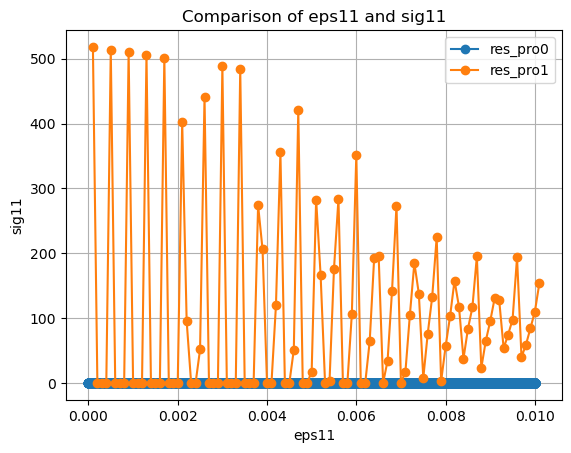

In [22]:
plt.plot(res_pro0['eps11'], res_pro0['sig11'], marker='o', label='res_pro0')
plt.plot(res_pro1['eps11'], res_pro1['sig11'], marker='o', label='res_pro1')
plt.xlabel('eps11')
plt.ylabel('sig11')
plt.title('Comparison of eps11 and sig11')
plt.legend()
plt.grid(True)
plt.show()

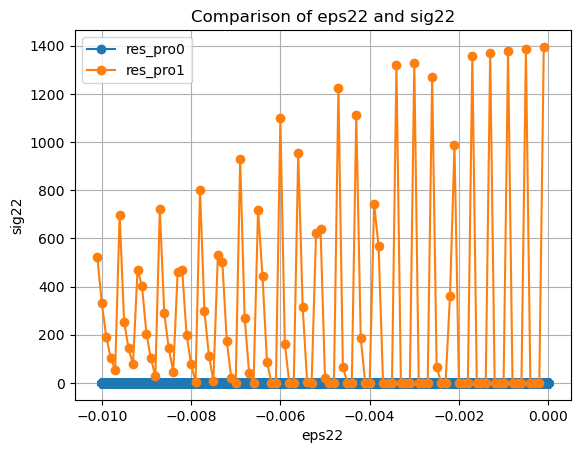

In [24]:
plt.plot(res_pro0['eps22'], res_pro0['sig22'], marker='o', label='res_pro0')
plt.plot(res_pro1['eps22'], res_pro1['sig22'], marker='o', label='res_pro1')
plt.xlabel('eps22')
plt.ylabel('sig22')
plt.title('Comparison of eps22 and sig22')
plt.legend()
plt.grid(True)
plt.show()